# **RF Constellation Impairment Classification**

Modern SDR workflows produce large amounts of I/Q data, and many of these frames contain impairments caused by hardware offsets, synchronization drift, or changes in channel conditions. In link-level experiments, waveform evaluations, or receiver prototyping, these imperfections can bias measurements or invalidate results. Being able to automatically label such frames helps determine whether they should be included in the analysis or discarded.

Manual inspection does not scale, especially when thousands of frames are involved. A lightweight model that identifies the impairment type directly from the constellation simplifies large-scale experiments and improves data reliability.

This project directly builds such a model using supervised learning on complex baseband constellation samples.

## **Objective**
Train a neural network to classify RF impairments using only a snapshot of I/Q symbols. Each input is a constellation frame produced by the receiver after standard front-end DSP. The network learns to recognize the geometric patterns associated with different distortions such as low SNR, CFO, phase offset, timing errors, and IQ imbalance.

## **Dataset**

A QPSK signal was transmitted and received using two Pluto SDRs placed close together to obtain a clean baseline waveform. The raw clean captures are provided in the repository as `rxData.mat`.

The receiver processed the signal with a standard DSP chain (AGC, filtering, synchronization). For each detected frame it produced a vector of complex symbols called symFrame (the constellation points after demod front-end).

These clean frames were saved in MATLAB as a matrix frames of size:

`Nsym × Nclean, where each column is one frame`

To obtain labeled data for supervised learning, controlled impairments were added synthetically to the clean constellations:

* AWGN noise (low SNR)

* Carrier frequency offset (CFO) → rotating cloud

* Static phase offset → rotated constellation

* Timing distortion / ISI → smeared/chaotic cloud

* IQ imbalance → skewed / elliptical clusters

Each impaired version of a frame was stored along with a class label:



```
0 = clean

1 = low SNR

2 = CFO residual

3 = static phase offset

4 = timing distortion

5 = IQ imbalance
```



The final dataset was saved to a single MATLAB file: datasetQPSK.mat, containing:

* Xmat — complex constellation samples, shape (Nsym, N_total)
* yvec — labels for each sample, shape (N_total,)
* Nsym — number of symbols per frame
* N_total — total number of samples

# Data extraction

Loading the `datasetQPSK.mat` file that was generated

In [24]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

# Make plots show up inline
%matplotlib inline


In [25]:
import h5py
import numpy as np

mat_path = "/content/datasetQPSK.mat"

with h5py.File(mat_path, "r") as f:
    X_raw = f["Xmat"][:]             # shape (12512, 5613)
    y_raw = f["yvec"][:]             # shape (12512,)
    Nsym = int(f["Nsym"][0][0])      # number of symbols per frame
    N_total = int(f["N_total"][0][0])# number of samples

# Reconstruct complex matrix correctly
real_part = X_raw["real"]            # (N_total, Nsym)
imag_part = X_raw["imag"]            # (N_total, Nsym)

# NO TRANSPOSE!
X = real_part + 1j * imag_part       # final shape: (12512, 5613)

# Labels
y = y_raw.astype(int).flatten()

print("Final X shape:", X.shape)
print("Final y shape:", y.shape)
print("Expected shape:", (N_total, Nsym))



Final X shape: (10166, 5613)
Final y shape: (10166,)
Expected shape: (10166, 5613)


## **Constellation visualization**

Before training any model, it is useful to visually inspect the data. This lets us confirm that the impairments generated in MATLAB produce the expected visual patterns (clean clusters, noisy clouds, rotating ring, IQ skew, etc.).

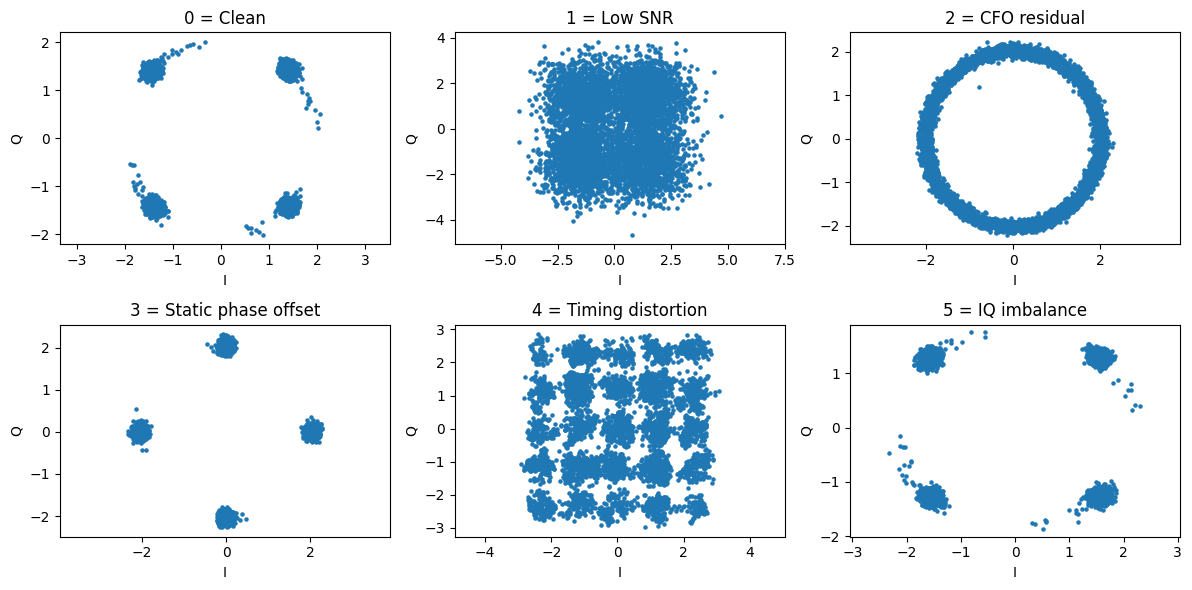

In [26]:

labels = {
    0: "0 = Clean",
    1: "1 = Low SNR",
    2: "2 = CFO residual",
    3: "3 = Static phase offset",
    4: "4 = Timing distortion",
    5: "5 = IQ imbalance",
}

plt.figure(figsize=(12, 6))

for cls in range(6):
    indices = np.where(y == cls)[0]
    idx = np.random.choice(indices)   # pick a random sample
    x_sample = X[idx]

    plt.subplot(2, 3, cls + 1)
    plt.scatter(np.real(x_sample), np.imag(x_sample), s=5)
    plt.title(labels[cls])
    plt.xlabel("I")
    plt.ylabel("Q")
    plt.axis("equal")

plt.tight_layout()
plt.show()



# Preprocessing



The dataset is stored as complex-valued constellation frames, where each row represents one captured frame and each column represents a symbol in that frame. Neural networks operate on real-valued tensors, so it is needed to convert each complex sample into two real-valued channels: the in-phase component and the quadrature component.

Constellation frames are currently stored as a 2-D complex matrix:

`X shape = (N_samples, N_symbols)`

Where each row contains the complex symbols of a single received frame.

To feed this into a neural model, we convert each constellation into two channels:

* **Channel 0 =** In-phase (real part)

* **Channel 1 =** Quadrature (imaginary part)

So each sample becomes a tensor of shape:

`(2, N_symbols)`


And the full dataset becomes:

`(N_samples, 2, N_symbols)`


This representation preserves full constellation geometry and is superior to image-based approaches for RF tasks.

In [27]:
# Convert to float32 two-channel tensors
X_real = np.real(X).astype(np.float32)
X_imag = np.imag(X).astype(np.float32)

# New shape: (N_samples, 2, N_symbols)
X_tensor = np.stack([X_real, X_imag], axis=1)

print("X_tensor shape:", X_tensor.shape)  # (12512, 2, 5613)
print("y shape:", y.shape)


X_tensor shape: (10166, 2, 5613)
y shape: (10166,)


## Train/Test Split
The dataset is divided into training and testing subsets. The split ensures that all impairment classes appear in both subsets.

Once the preprocessing is complete, we create a PyTorch Dataset and DataLoader to supply mini-batches of samples during training. This step prepares the data for the neural network that will classify the impairment type for each constellation snapshot.

In [28]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader

class ConstellationDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# First split: train vs temp (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_tensor, y, test_size=0.3, random_state=42, stratify=y
)

# Second split: val vs test (half of temp each)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Datasets
train_ds = ConstellationDataset(X_train, y_train)
val_ds   = ConstellationDataset(X_val,   y_val)
test_ds  = ConstellationDataset(X_test,  y_test)

# Dataloaders
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl   = DataLoader(val_ds,   batch_size=64, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size=64, shuffle=False)

print("Train:", len(train_ds))
print("Val:",   len(val_ds))
print("Test:",  len(test_ds))



Train: 7116
Val: 1525
Test: 1525


### Sanity Check

In [29]:
xb, yb = next(iter(train_dl))

print("Batch X shape:", xb.shape)  # (batch, 2, N_symbols)
print("Batch y shape:", yb.shape)  # (batch,)

# Example batch stats
print("X min:", xb.min().item(), "X max:", xb.max().item())
print("Unique labels in batch:", torch.unique(yb))


Batch X shape: torch.Size([64, 2, 5613])
Batch y shape: torch.Size([64])
X min: -4.872411727905273 X max: 4.678467273712158
Unique labels in batch: tensor([0, 1, 2, 3, 4, 5])


# NN Model

Each sample is represented as two real-valued channels (I and Q) over a sequence of symbols, so a 1D convolutional neural network is a natural choice.
The model starts with a stack of convolution layers that extract local structure from the symbol sequence. These layers learn characteristic patterns produced by each impairment, such as rotation from CFO, amplitude skew from IQ imbalance, or noise-induced spreading. After the convolution stage, the features are compressed and passed to a small fully connected classifier that outputs one of the six impairment classes.

In [30]:
import torch.nn as nn
import torch

class CNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv1d(2, 16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(32)   # compress symbol dimension to length 32
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 32, 128),
            nn.ReLU(),
            nn.Linear(128, 6)  # 6 impairment classes
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = CNNClassifier().cuda()
print(model)


CNNClassifier(
  (features): Sequential(
    (0): Conv1d(2, 16, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (3): ReLU()
    (4): AdaptiveAvgPool1d(output_size=32)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=6, bias=True)
  )
)


## Training

The training process is organized into three functions.

train_step performs one full pass over the training set and updates the model weights.

validate_step computes loss and accuracy on the validation set without modifying the model.

train_model coordinates the full training loop, applies early stopping, and stores the best-performing model based on validation loss.

This structure keeps the notebook organized and makes the training behavior easier to understand and modify.

In [31]:
import torch
import torch.nn.functional as F
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [32]:
def train_step(model, optimizer, train_loader):
    model.train()

    total_loss = 0
    total_correct = 0
    total_samples = 0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = F.cross_entropy(logits, yb)

        loss.backward()
        optimizer.step()

        preds = logits.argmax(dim=1)
        total_correct += (preds == yb).sum().item()
        total_loss += loss.item() * xb.size(0)
        total_samples += xb.size(0)

    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples

    return avg_acc, avg_loss


def validate_step(model, val_loader):
    model.eval()

    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            logits = model(xb)
            loss = F.cross_entropy(logits, yb)

            preds = logits.argmax(dim=1)
            total_correct += (preds == yb).sum().item()
            total_loss += loss.item() * xb.size(0)
            total_samples += xb.size(0)

    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples

    return avg_acc, avg_loss


def train_model(model, train_loader, val_loader, lr=1e-3, epochs=50, patience=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float("inf")
    best_state = None
    no_improve = 0

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        train_acc, train_loss = train_step(model, optimizer, train_loader)
        val_acc, val_loss = validate_step(model, val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1:02d} "
              f"- Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} "
              f"- Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"Early stopping triggered after {patience} epochs.")
                break

    model.load_state_dict(best_state)

    return model, train_losses, val_losses



Epoch 01 - Train Loss: 1.2539, Acc: 0.4897 - Val Loss: 0.8628, Acc: 0.6033
Epoch 02 - Train Loss: 0.7548, Acc: 0.6442 - Val Loss: 0.7035, Acc: 0.7698
Epoch 03 - Train Loss: 0.5843, Acc: 0.7354 - Val Loss: 0.4706, Acc: 0.7954
Epoch 04 - Train Loss: 0.4255, Acc: 0.8288 - Val Loss: 0.3638, Acc: 0.7744
Epoch 05 - Train Loss: 0.2930, Acc: 0.9165 - Val Loss: 0.3365, Acc: 0.7764
Epoch 06 - Train Loss: 0.2227, Acc: 0.9396 - Val Loss: 0.1735, Acc: 0.9298
Epoch 07 - Train Loss: 0.1384, Acc: 0.9784 - Val Loss: 0.1163, Acc: 0.9948
Epoch 08 - Train Loss: 0.1385, Acc: 0.9594 - Val Loss: 0.1277, Acc: 0.9397
Epoch 09 - Train Loss: 0.0756, Acc: 0.9923 - Val Loss: 0.0472, Acc: 1.0000
Epoch 10 - Train Loss: 0.0470, Acc: 0.9979 - Val Loss: 0.0377, Acc: 1.0000
Epoch 11 - Train Loss: 0.0356, Acc: 0.9989 - Val Loss: 0.0239, Acc: 1.0000
Epoch 12 - Train Loss: 0.0266, Acc: 0.9990 - Val Loss: 0.0178, Acc: 1.0000
Epoch 13 - Train Loss: 0.0214, Acc: 0.9992 - Val Loss: 0.0153, Acc: 1.0000
Epoch 14 - Train Loss: 0.

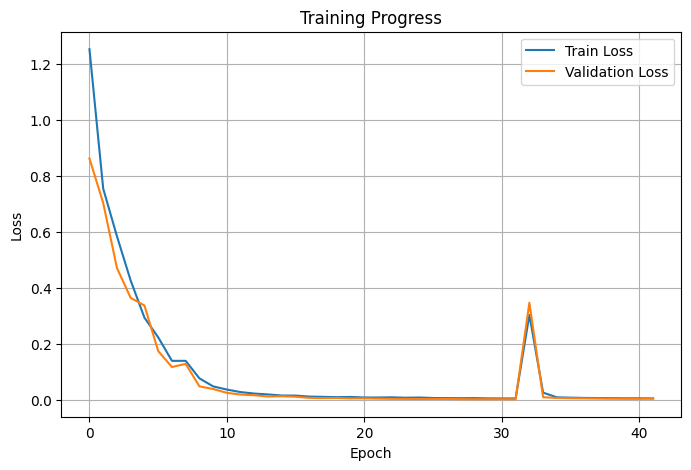

In [33]:
trained_model, train_losses, val_losses = train_model(
    model, train_dl, val_dl, lr=1e-3, epochs=50, patience=10
)

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Progress")
plt.legend()
plt.grid(True)
plt.show()



## Evaluation

Meausuring model’s performance on the test set.

The evaluation stage computes the overall accuracy and produces a confusion matrix. This helps visualize how well the model distinguishes between impairment classes and whether any particular category is being misclassified.

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate(model, test_loader):
    model.eval()

    total_correct = 0
    total_samples = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            logits = model(xb)
            preds = logits.argmax(dim=1)

            total_correct += (preds == yb).sum().item()
            total_samples += yb.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    accuracy = total_correct / total_samples
    print(f"Test Accuracy: {accuracy:.4f}")

    return np.array(all_labels), np.array(all_preds)


Test Accuracy: 0.9980


<Figure size 600x500 with 0 Axes>

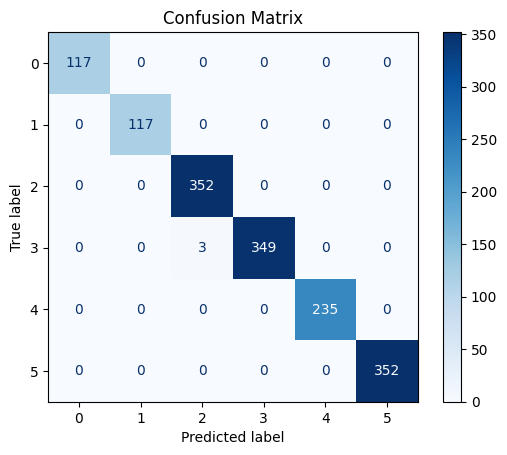

In [35]:
labels, preds = evaluate(model, test_dl)

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3,4,5])

plt.figure(figsize=(6,5))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


## Conclusion

The classifier achieves nearly perfect separation between all six impairment types using only the constellation samples as input.

It can be concluded that even a lightweight 1D CNN is sufficient to capture the structure of common RF impairments directly from baseband I/Q data. For SDR experimentation, this provides a practical tool for automatically filtering out distorted frames, labeling impairments during data collection, or monitoring link health without manual inspection.

The approach can scale well, requires minimal preprocessing, and can be adapted to other modulations or additional impairment types. This makes it useful both as a diagnostic component in receiver pipelines and as a dataset-cleaning step in research workflows where only high-quality frames should be included in performance evaluations.
